In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from scipy.io import readsav
from scipy import ndimage
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# import math
import glob as glob
import seaborn as sns

# PyMC 4.0 imports
import pymc as pm
import aesara.tensor as at 
import aesara
import arviz as az
import pymc.sampling_jax
import pytensor.tensor as pt
import pytensor

import sys
sys.path.append('../')

from scipy import stats

import os

from funciones.opencube2 import opencube2
from funciones.func4 import tilt,elong,MFLUX,barys,set_ranges,sizes
from funciones.modelcube import modelmag,modelmagf,modelmag2

In [18]:
DF0=pd.read_csv('./arangosx.csv',index_col=0)

In [19]:
DF0['AR']

0      10132
1      10323
2      10344
3      10381
4      10569
       ...  
121     9910
122     9912
123     9931
124     9978
125     9987
Name: AR, Length: 126, dtype: int64

In [20]:
#sig={}

#for name in list(DF0['AR'].values):
#print(list(DF0['AR'].values))
#name=str(input('insert AR name'))
name=10268
print(str(name)+'----------------------------------')
datad,times=opencube2(name=str(name),path='../movies')
scl=1


nn=DF0[DF0['AR']==int(name)].range.values[0]
sg0=DF0[DF0['AR']==int(name)].sigma.values[0]

mask_cube=np.load('./masks/'+str(name)+'_mask.npy')[:,:,0:nn]
mod_cube=np.load('./models/'+str(name)+'.npy')[:,:,0:nn]

data2=datad[:,:,0:nn]#*mask_cube

sz2,sz1,nMagnetograms = (np.shape(data2))

stp=round(nMagnetograms/np.shape(mod_cube)[2])

data2=data2[:,:,::stp]
mask=mask_cube[:,:,::stp]

cubedif=(mod_cube-data2)*(mask>0)

#sg1=np.std(mod_cube[mask>0]-data2[mask>0],axis=(0,1))
    
#    sig[name]=[sg0,np.std(mod_cube[mask>0]-data2[mask>0])]


10268----------------------------------
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64


In [21]:
stp

3

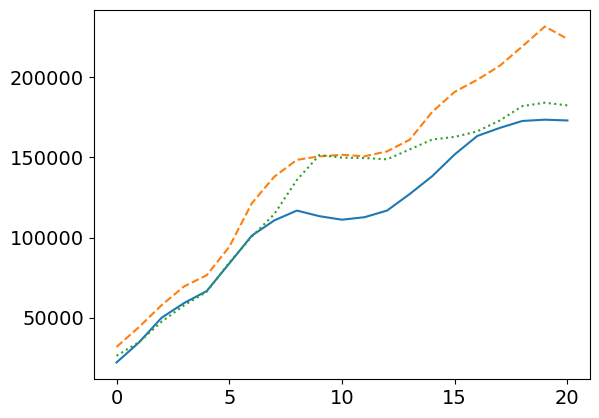

In [22]:
plt.plot(np.sum(mod_cube*(mod_cube>0)*(mask>0),axis=(0,1)))
plt.plot(np.sum(data2*(data2>0)*(mask>0),axis=(0,1)),linestyle='dashed')
plt.plot(-1*np.sum(data2*(data2<0)*(mask>0),axis=(0,1)),linestyle='dotted')


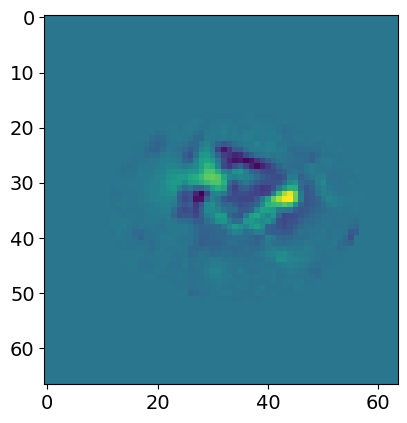

In [23]:
plt.imshow(cubedif[:,:,5])

(-1000.0, 1000.0)

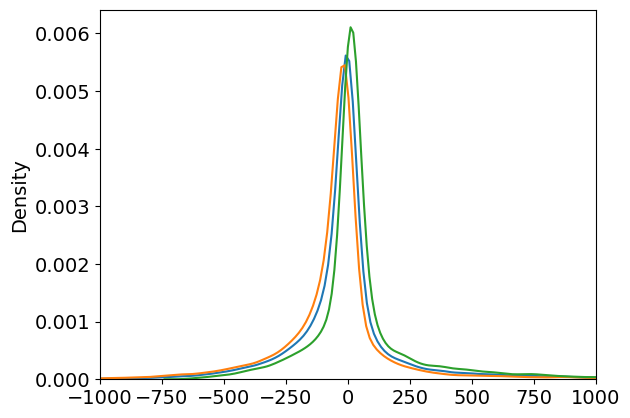

In [24]:
cube_t=cubedif[:,:,15]

#sns.histplot(np.ravel(cubedif[np.abs(cubedif)> 0]),bins=22)
sns.kdeplot(np.ravel(cubedif[np.abs(cubedif)> 0]))
sns.kdeplot(np.ravel(cubedif[np.abs(cubedif*(data2>0))> 0]))
sns.kdeplot(np.ravel(cubedif[np.abs(cubedif*(data2<0))> 0]))

plt.xlim(-1000,1000)

#sns.histplot(np.ravel(cube_t*(np.abs(cube_t)> 0)),bins=22)

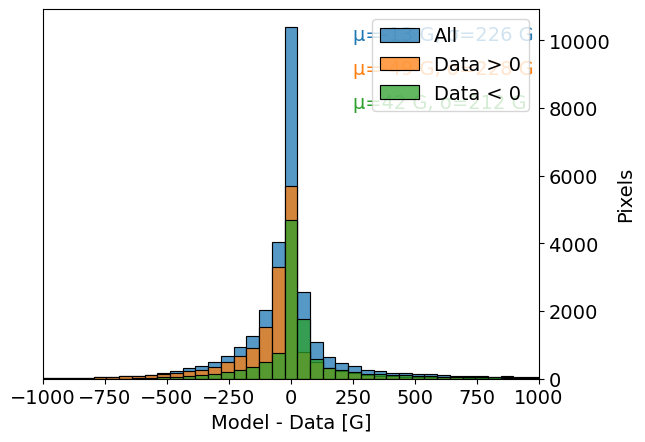

In [25]:
bin_edges = np.linspace(-1000, 1000, 40)

plt.rcParams.update({'font.size': 14})


dat1=np.ravel(cubedif[np.abs(cubedif)> 0])
dat2=np.ravel(cubedif[np.abs(cubedif*(data2*mask>0))> 0])
dat3=np.ravel(cubedif[np.abs(cubedif*(data2*mask<0))> 0])
mean1, std1 = np.mean(dat1), np.std(dat1)
mean2, std2 = np.mean(dat2), np.std(dat2)
mean3, std3 = np.mean(dat3), np.std(dat3)

sns.histplot(dat1,bins=bin_edges,label='All')
sns.histplot(dat2,bins=bin_edges,label='Data > 0')
sns.histplot(dat3,bins=bin_edges,label='Data < 0')

plt.legend()

plt.text(250, 10000, f'µ={mean1:.0f} G, σ={std1:.0f} G', color='tab:blue')
plt.text(250, 9000, f'µ={mean2:.0f} G, σ={std2:.0f} G', color='tab:orange')
plt.text(250, 8000, f'µ={mean3:.0f} G, σ={std3:.0f} G', color='tab:green')

ax=plt.gca()
# Mover el y-axis al lado derecho
ax.yaxis.set_label_position("right")  # Mueve la etiqueta (ylabel) a la derecha
ax.yaxis.tick_right()

plt.xlim(-1000,1000)
plt.ylabel('Pixels')

plt.xlabel('Model - Data [G]')

plt.savefig('./plots/histoerr.pdf',dpi=300)

In [26]:
dat1

array([-83.72431055, -93.57146076, -52.93577918, ..., -33.17241632,
        20.93781311,  16.75031434])

In [27]:
100*np.sum(np.abs(dat1) <120)/len(dat1)

69.29685574451604

In [28]:
# Configuración de los edges y fuentes
bin_edges = np.linspace(-1000, 1000, 22)
plt.rcParams.update({'font.size': 14})

meana=np.zeros((3,21))
stda=np.zeros((3,21))

for i in range(cubedif.shape[2]):
    dat1 = np.ravel(cubedif[:,:,i][np.abs(cubedif[:,:,i]) > 0])
    dat2 = np.ravel(cubedif[:,:,i][(cubedif[:,:,i] * (data2[:,:,i] * mask[:,:,i] > 0)) != 0])
    dat3 = np.ravel(cubedif[:,:,i][(cubedif[:,:,i] * (data2[:,:,i] * mask[:,:,i] < 0)) != 0])

    for e,dd in enumerate([dat1,dat2,dat3]):
        mean1, std1 = np.mean(dd), np.std(dd)

        meana[e,i]=mean1
        stda[e,i]=std1
    


In [29]:
ldf=[]

for i in range(cubedif.shape[2]):
    dat1 = np.ravel(cubedif[:,:,i][np.abs(cubedif[:,:,i]) > 0])
    dat2 = np.ravel(cubedif[:,:,i][(cubedif[:,:,i] * (data2[:,:,i] * mask[:,:,i] > 0)) != 0])
    dat3 = np.ravel(cubedif[:,:,i][(cubedif[:,:,i] * (data2[:,:,i] * mask[:,:,i] < 0)) != 0])
    
    df1=pd.DataFrame({'values':dat1,'data':'All','mag':i})
    df2=pd.DataFrame({'values':dat2,'data':'Data > 0','mag':i})
    df3=pd.DataFrame({'values':dat3,'data':'Data < 0','mag':i})
    
    ldf.append(pd.concat([df1,df2,df3]))
    
DFx=pd.concat(ldf)

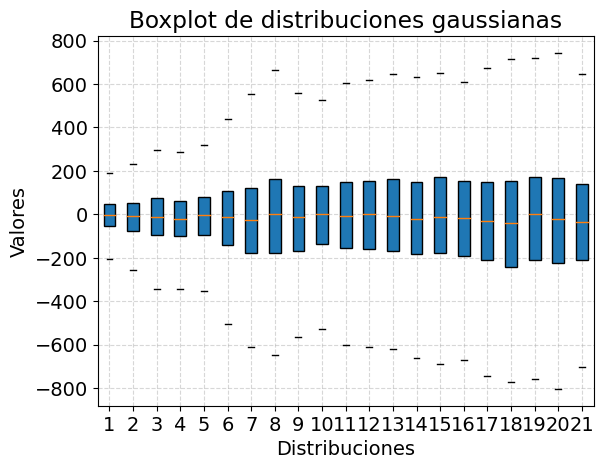

In [30]:

import numpy as np
import matplotlib.pyplot as plt


# Listas de valores medios y desviaciones estándar
means = list(meana[0,:])
stds = list(stda[0,:])

# Generar muestras gaussianas para cada par (mean, std)
samples = [np.random.normal(loc=mean, scale=std, size=1000) for mean, std in zip(means, stds)]
# Listas de valores medios y desviaciones estándar
means = list(meana[1,:])
stds = list(stda[1,:])

# Generar muestras gaussianas para cada par (mean, std)
samples1 = [np.random.normal(loc=mean, scale=std, size=1000) for mean, std in zip(means, stds)]
# Listas de valores medios y desviaciones estándar
means = list(meana[2,:])
stds = list(stda[2,:])

# Generar muestras gaussianas para cada par (mean, std)
samples2 = [np.random.normal(loc=mean, scale=std, size=1000) for mean, std in zip(means, stds)]

# Crear el boxplot
#plt.figure(figsize=(8, 6))
plt.boxplot(samples, vert=True, patch_artist=True,showfliers=False,whiskerprops=dict(linestyle=""))

plt.xlabel('Distribuciones')
plt.ylabel('Valores')
plt.title('Boxplot de distribuciones gaussianas')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [31]:
df1=pd.DataFrame({'sample':np.ravel(samples),'model':'all','mag':np.ravel([i*np.ones_like(samples[i]) for i in range(21)])})
df2=pd.DataFrame({'sample':np.ravel(samples1),'model':'positive','mag':np.ravel([i*np.ones_like(samples[i]) for i in range(21)])})
df3=pd.DataFrame({'sample':np.ravel(samples2),'model':'negative','mag':np.ravel([i*np.ones_like(samples[i]) for i in range(21)])})

In [32]:
DFall=pd.concat([df1,df2,df3])

In [33]:
# Usar jointplot con boxplot y un histograma en el margen derecho
g = sns.jointplot(
    data=DFx, 
    x='mag',
    y='values',
    hue='data',    
    kind='box',  # Boxplot principal
    marginal_kws=dict(bins=30, fill=True, cumulative=True)  # Histograma acumulado en el margen
)

# Personalizar etiquetas y título
g.ax_joint.set_xlabel('Valores')
g.ax_joint.set_ylabel('Densidad')
plt.suptitle('Boxplot con histograma acumulado a la derecha', y=1.02)

plt.show()


ValueError: `kind` must be one of ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid'], but 'box' was passed.

In [38]:
DFx['mag']=DFx['mag'].apply(lambda x: x*3+1)

In [50]:
np.arange(1,62,9)

array([ 1, 10, 19, 28, 37, 46, 55])

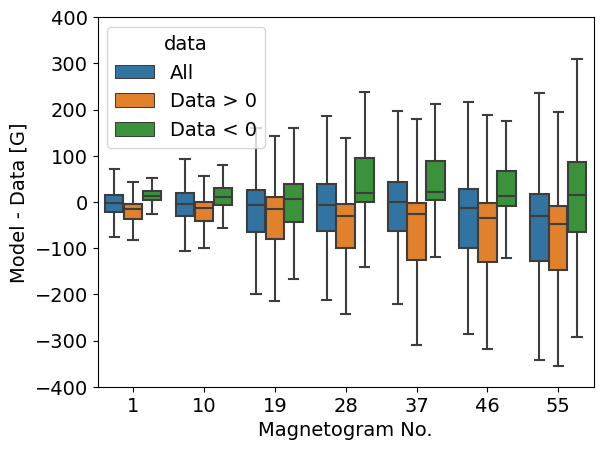

In [53]:
sns.boxplot(data=DFx[DFx['mag'].isin(np.arange(1,62,9))],x='mag',y='values',hue='data',showfliers=False)
plt.ylim(-400,400)

plt.ylabel('Model - Data [G]')
plt.xlabel('Magnetogram No.')

plt.savefig('./plots/boxsample.pdf',dpi=300)

Amplitud: 6584.13, Media: -5.45, Desviación estándar: 36.26
Amplitud: 5496.03, Media: -20.13, Desviación estándar: 21.82
Amplitud: 4412.65, Media: 17.24, Desviación estándar: 19.52


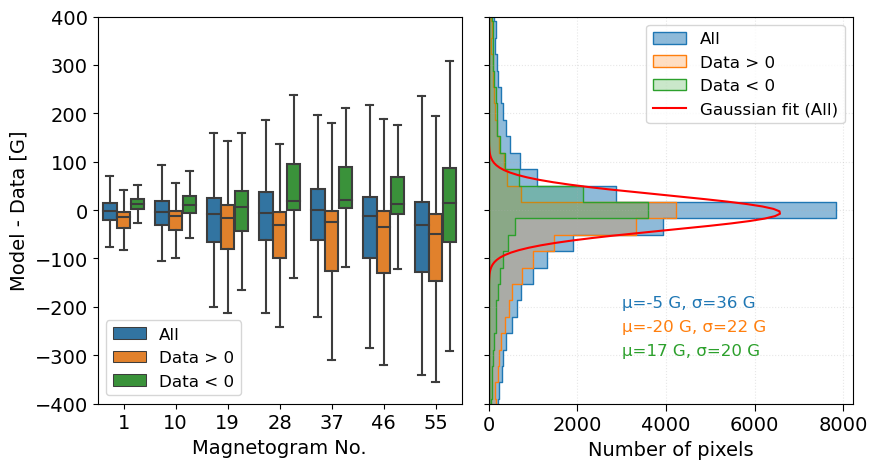

In [144]:
# Create the joint grid
g = sns.JointGrid(data=DFx, x='mag', y='values', height=9,ratio=1)

# Add boxplot to the central axes
sns.boxplot(data=DFx[DFx['mag'].isin(np.arange(1,62,9))],x='mag',y='values',hue='data',showfliers=False,ax=g.ax_joint)
#sns.boxplot(data=tips, x='total_bill', y='day', ax=g.ax_joint)

g.ax_joint.set_ylim(-400,400)
# Eliminar la marginal del eje x y mantener la del eje y
g.ax_marg_x.remove()  # Elimina la marginal superior

g.ax_joint.legend(fontsize=12,title='',loc='lower left')

# Filtrado de datos
dat1 = np.ravel(cubedif[np.abs(cubedif) > 0])
dat2 = np.ravel(cubedif[(cubedif * (data2 * mask > 0)) != 0])
dat3 = np.ravel(cubedif[(cubedif * (data2 * mask < 0)) != 0])

# Cálculo de estadísticas
mean1, std1 = np.mean(dat1), np.std(dat1)
mean2, std2 = np.mean(dat2), np.std(dat2)
mean3, std3 = np.mean(dat3), np.std(dat3)

# Configuración de los edges y fuentes
bin_edges = np.linspace(-1000, 1000, 60)

# Histograma
sns.histplot(y=dat1, bins=bin_edges, label='All', element="step", color='tab:blue', alpha=0.5,ax=g.ax_marg_y,stat='count')
sns.histplot(y=dat2, bins=bin_edges, label='Data > 0', element="step", color='tab:orange', alpha=0.25,ax=g.ax_marg_y,stat='count')
sns.histplot(y=dat3, bins=bin_edges, label='Data < 0', element="step", color='tab:green', alpha=0.25,ax=g.ax_marg_y,stat='count')

# Histograma
hist1, bin_edges = np.histogram(dat1,range=(-1000,1000), bins=60, density=False)
hist2, bin_edges = np.histogram(dat2,range=(-1000,1000), bins=60, density=False)
hist3, bin_edges = np.histogram(dat3,range=(-1000,1000), bins=60, density=False)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Ajuste gaussiano
popt1, pcov2 = curve_fit(gaussian, bin_centers, hist1, p0=[np.max(hist1), np.mean(dat1), np.std(dat1)])
popt2, pcov2 = curve_fit(gaussian, bin_centers, hist2, p0=[np.max(hist2), np.mean(dat2), np.std(dat2)])
popt3, pcov2 = curve_fit(gaussian, bin_centers, hist3, p0=[np.max(hist3), np.mean(dat3), np.std(dat3)])

#h=0.9
colorx=['tab:blue','tab:orange','tab:green']
# Parámetros del ajuste
for i,popt in enumerate([popt1,popt2,popt3]):
    amp, mu, sigma = popt
    print(f"Amplitud: {amp:.2f}, Media: {mu:.2f}, Desviación estándar: {sigma:.2f}")
    # Anotaciones automáticas basadas en el límite superior del eje y
   # y_max = plt.gca().get_ylim()[1]
    g.ax_marg_y.text(3000, -200 -50*i, f'µ={mu:.0f} G, σ={sigma:.0f} G', color=colorx[i],fontsize=12)

    
#plt.hist(bin_edges,y=dat1, bins=40, density=False, alpha=0.5, label='Datos')
# Graficar
#plt.hist(data, bins=40, density=True, alpha=0.5, label='Datos')
x_fit = np.linspace(-1000, 1000, 400)
plt.plot( gaussian(x_fit, *popt1),x_fit, 'r-', label='Gaussian fit (All)')

# Make axis elements visible
g.ax_marg_y.spines['left'].set_visible(True)
g.ax_marg_y.spines['bottom'].set_visible(True)
g.ax_marg_y.spines['top'].set_visible(True)
g.ax_marg_y.spines['right'].set_visible(True)
g.ax_joint.spines['top'].set_visible(True)
g.ax_joint.spines['right'].set_visible(True)

# Configure ticks
g.ax_marg_y.tick_params(axis='x', which='major', 
                       length=5, labelsize=14,
                       bottom=True,
                       labelbottom=True)

# Add axis labels
g.ax_marg_y.set_xlabel('Number of pixels', fontsize=14, visible=True)
g.ax_joint.set_xlabel('Magnetogram No.', fontsize=14, visible=True)
g.ax_joint.set_ylabel('Model - Data [G]', fontsize=14, visible=True)


# Optional: Add grid
g.ax_marg_y.grid(True, linestyle=':', alpha=0.3)

# Graficar la curva gaussiana
#plt.plot( y_gauss_scaled,x_gauss, color='tab:blue', lw=2, label='Gaussian fit (All)')
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig('./plots/boxsample.pdf',dpi=300)
plt.show()

In [210]:
# Función gaussiana
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

Amplitud: 9399.58, Media: -9.16, Desviación estándar: 59.83


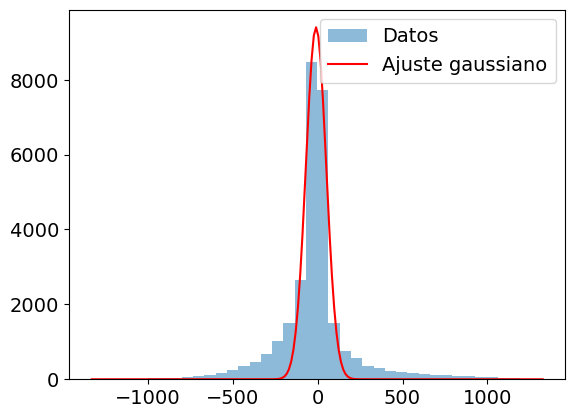

In [95]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Función gaussiana
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Datos de ejemplo (reemplaza con tus datos)
data = DFx[DFx.data=='All']['values']

# Histograma
hist, bin_edges = np.histogram(data, bins=40, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Ajuste gaussiano
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[1, np.mean(data), np.std(data)])

# Parámetros del ajuste
amp, mu, sigma = popt
print(f"Amplitud: {amp:.2f}, Media: {mu:.2f}, Desviación estándar: {sigma:.2f}")

# Graficar
plt.hist(data, bins=40, density=False, alpha=0.5, label='Datos')
x_fit = np.linspace(min(data), max(data), 200)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Ajuste gaussiano')
plt.legend()
plt.show()

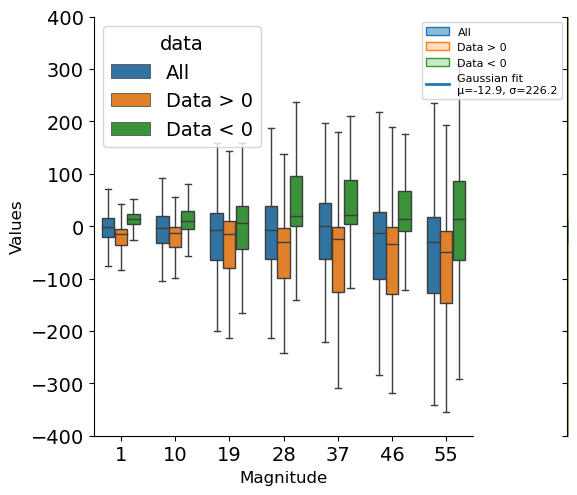

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Create the joint grid with wider aspect ratio
g = sns.JointGrid(data=DFx, x='mag', y='values', height=6, ratio=5, space=0.1)
plt.subplots_adjust(left=0.1, right=0.9)  # Adjust margins for wider figure

# Add boxplot to the central axes
sns.boxplot(data=DFx[DFx['mag'].isin(np.arange(1,62,9))],
            x='mag', y='values', hue='data', 
            showfliers=False, ax=g.ax_joint,
            width=0.7, linewidth=1)

g.ax_joint.set_ylim(-400, 400)
g.ax_joint.set_xlabel('Magnitude', fontsize=12)
g.ax_joint.set_ylabel('Values', fontsize=12)

# Remove x marginal
g.ax_marg_x.remove()

# Filter data
dat1 = np.ravel(cubedif[np.abs(cubedif) > 0])
dat2 = np.ravel(cubedif[(cubedif * (data2 * mask > 0)) != 0])
dat3 = np.ravel(cubedif[(cubedif * (data2 * mask < 0)) != 0])

# Calculate statistics
mean1, std1 = np.mean(dat1), np.std(dat1)
mean2, std2 = np.mean(dat2), np.std(dat2)
mean3, std3 = np.mean(dat3), np.std(dat3)

# Set bin edges
bin_edges = np.linspace(-400, 400, 40)

# Plot histograms on y-marginal (rotated)
sns.histplot(y=dat1, bins=bin_edges, label='All', 
             element="step", color='tab:blue', alpha=0.5, ax=g.ax_marg_y)
sns.histplot(y=dat2, bins=bin_edges, label='Data > 0', 
             element="step", color='tab:orange', alpha=0.25, ax=g.ax_marg_y)
sns.histplot(y=dat3, bins=bin_edges, label='Data < 0', 
             element="step", color='tab:green', alpha=0.25, ax=g.ax_marg_y)

# Create and plot Gaussian curve
x_gauss = np.linspace(-400, 400, 400)
y_gauss = norm.pdf(x_gauss, mean1, std1)
y_gauss_scaled = y_gauss * len(dat1) * (bin_edges[1] - bin_edges[0])

# Plot Gaussian fit
g.ax_marg_y.plot(y_gauss_scaled, x_gauss, color='tab:blue', lw=2, 
                label=f'Gaussian fit\nμ={mean1:.1f}, σ={std1:.1f}')

# Set y-marginal axis scale to match main plot
g.ax_marg_y.set_ylim(-400, 400)
g.ax_marg_y.set_xlabel('Count', fontsize=10)
g.ax_marg_y.legend(loc='upper right', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()

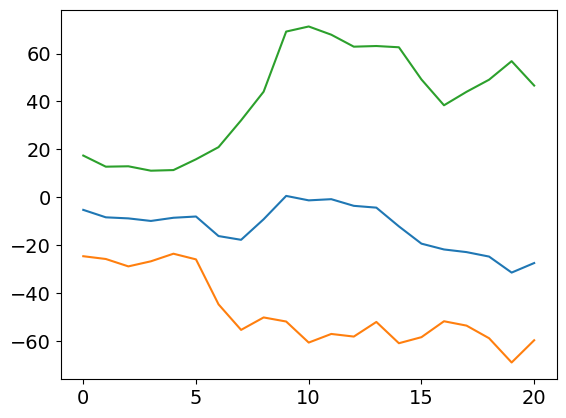

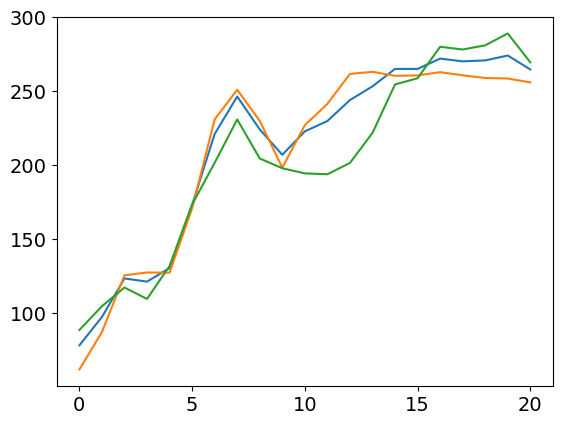

In [64]:
for i in range(3):
    plt.plot(meana[i,:])
plt.show()

for i in range(3):
    plt.plot(stda[i,:])
plt.show()
    


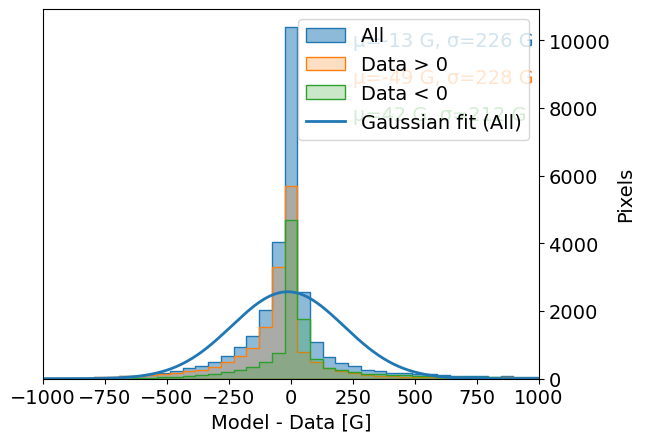

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


# Configuración de los edges y fuentes
bin_edges = np.linspace(-1000, 1000, 40)
plt.rcParams.update({'font.size': 14})

# Filtrado de datos
dat1 = np.ravel(cubedif[np.abs(cubedif) > 0])
dat2 = np.ravel(cubedif[(cubedif * (data2 * mask > 0)) != 0])
dat3 = np.ravel(cubedif[(cubedif * (data2 * mask < 0)) != 0])

# Cálculo de estadísticas
mean1, std1 = np.mean(dat1), np.std(dat1)
mean2, std2 = np.mean(dat2), np.std(dat2)
mean3, std3 = np.mean(dat3), np.std(dat3)

# Histograma
sns.histplot(dat1, bins=bin_edges, label='All', element="step", color='tab:blue', alpha=0.5)
sns.histplot(dat2, bins=bin_edges, label='Data > 0', element="step", color='tab:orange', alpha=0.25)
sns.histplot(dat3, bins=bin_edges, label='Data < 0', element="step", color='tab:green', alpha=0.25)

# Leyenda
plt.legend()

# Anotaciones automáticas basadas en el límite superior del eje y
y_max = plt.gca().get_ylim()[1]
plt.text(250, y_max * 0.9, f'µ={mean1:.0f} G, σ={std1:.0f} G', color='tab:blue')
plt.text(250, y_max * 0.8, f'µ={mean2:.0f} G, σ={std2:.0f} G', color='tab:orange')
plt.text(250, y_max * 0.7, f'µ={mean3:.0f} G, σ={std3:.0f} G', color='tab:green')

# Crear la curva gaussiana
x_gauss = np.linspace(-1000, 1000, 500)
y_gauss = norm.pdf(x_gauss, mean1, std1)  # Densidad de probabilidad gaussiana
y_gauss_scaled = y_gauss * len(dat1) * (bin_edges[1] - bin_edges[0])  # Escalar según el histograma

# Graficar la curva gaussiana
plt.plot(x_gauss, y_gauss_scaled, color='tab:blue', lw=2, label='Gaussian fit (All)')
plt.legend()

# Mover el y-axis al lado derecho
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# Límites y etiquetas
plt.xlim(-1000, 1000)
plt.ylabel('Pixels')
plt.xlabel('Model - Data [G]')

# Guardar el gráfico
plt.savefig('./plots/histoerr_with_gaussian.pdf', dpi=300)
plt.show()


In [225]:
sig={}
means={}
ffm={}
pixsize=1.98*725*1000*100
pixarea=pixsize*pixsize

for name in list(DF0['AR'].values):
    print(str(name)+'----------------------------------')
    datad,times=opencube2(name=str(name),path='../movies')
    scl=1
    
    
    nn=DF0[DF0['AR']==name].range.values[0]
    sg0=DF0[DF0['AR']==name].sigma.values[0]
    
    mask_cube=np.load('./masks/'+str(name)+'_mask.npy')[:,:,0:nn]
    mod_cube=np.load('./models/'+str(name)+'.npy')[:,:,0:nn]
    mod_cube0=np.load('./masks/'+str(name)+'_mod0.npy')[:,:,0:nn]
    
    
    data2=datad[:,:,0:nn]#*mask_cube

    sz2,sz1,nMagnetograms = (np.shape(data2))
    
    stp=round(nMagnetograms/np.shape(mod_cube)[2])
    
    data2=data2[:,:,::stp]
    mod_cube0=mod_cube0[:,:,::stp]    
    flux_ar=np.sum(np.abs(data2)/2,axis=(0,1))
    mask=mask_cube[:,:,::stp]
    
    cubedif=mod_cube[mask>0]-data2[mask>0]
    cubedif2=mod_cube0[mask>0]-data2[mask>0]
    

    dat1 = np.ravel(cubedif[np.abs(cubedif) > 0])
    dat2 = np.ravel(cubedif2[np.abs(cubedif2) > 0])

    # Configuración de los edges y fuentes
    bin_edges = np.linspace(-1000, 1000, 60)


    # Histograma
    hist1, bin_edges = np.histogram(dat1,range=(-1000,1000), bins=60, density=False)
    hist2, bin_edges = np.histogram(dat2,range=(-1000,1000), bins=60, density=False)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Ajuste gaussiano
    popt1, pcov2 = curve_fit(gaussian, bin_centers, hist1, p0=[np.max(hist1), np.mean(dat1), np.std(dat1)])
    popt2, pcov2 = curve_fit(gaussian, bin_centers, hist2, p0=[np.max(hist2), np.mean(dat2), np.std(dat2)])

    amp, mu, sigma = popt1
    amp2, mu2, sigma2 = popt2
    
    sig[name]=[sigma2,sigma]
    means[name]=[mu2,mu]
    ffm[name]=np.max(flux_ar)*pixarea
    

10132----------------------------------
133 123 33
b'21-Sep-2002 22:23:01.298' b'24-Sep-2002 03:11:01.344'
75 84
10323----------------------------------
155 193 68
b'27-Mar-2003 14:24:00.501' b'1-Apr-2003 03:12:00.557'
96 159
10344----------------------------------
231 171 68
b'25-Apr-2003 16:03:00.390' b'30-Apr-2003 04:47:00.310'
73 119
10381----------------------------------
145 137 57
b'9-Jun-2003 22:22:59.390' b'13-Jun-2003 17:34:59.340'
70 88
10569----------------------------------
96 119 68
b'4-Mar-2004 19:15:03.230' b'9-Mar-2004 08:03:03.330'
71 103
10879----------------------------------
143 151 65
b'1-May-2006 11:11:01.530' b'5-May-2006 19:11:01.450'
71 96
10900----------------------------------
163 191 68
b'15-Jul-2006 17:36:01.630' b'20-Jul-2006 06:23:01.750'
91 141
10971----------------------------------
151 169 56
b'28-Sep-2007 00:03:02.040' b'1-Oct-2007 17:36:01.940'
57 86
11024----------------------------------
137 157 48
b'4-Jul-2009 00:00:02.090' b'7-Jul-2009 04:48:02.

In [226]:
df=pd.DataFrame.from_dict(sig, orient='index', columns=['S0', 'S1'])



In [227]:
df

,S0,S1
10132,34.795912,33.539600
10323,35.572794,28.571433
10344,46.954256,39.452816
10381,36.701032,29.377426
10569,35.353435,23.667108
...,...,...
9910,33.803161,27.796140
9912,36.710212,34.193144
9931,37.541796,33.143705
9978,53.161613,45.795050


In [229]:
dfm=pd.DataFrame.from_dict(means, orient='index',columns=['M0','M1'])

In [230]:
dfm

,M0,M1
10132,-0.591582,0.720833
10323,3.178543,3.705450
10344,-0.858108,-4.153537
10381,4.411261,4.142033
10569,-0.275077,1.920529
...,...,...
9910,-6.009450,-6.240658
9912,0.428233,4.288449
9931,0.645909,-0.034082
9978,-3.886281,-5.345208


In [245]:
df=df.assign(fmax=ffm)

/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Text(0, 0.5, 'ARs')

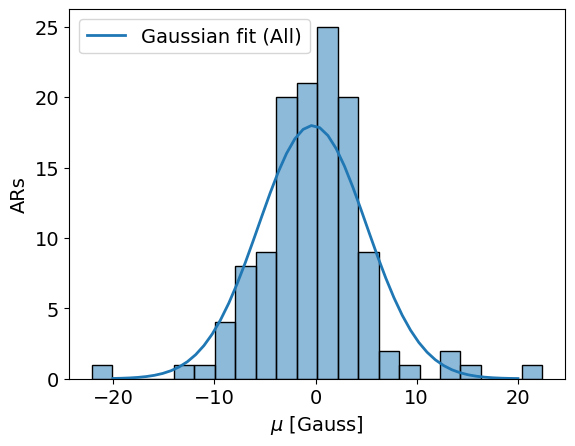

In [178]:
sns.histplot(dfm,color='tab:orange',alpha=0.5)

# Cálculo de estadísticas
mean1, std1 = np.mean(dfm), np.std(dfm)
# Configuración de los edges y fuentes
bin_edges = np.linspace(-20, 20, 22)

# Crear la curva gaussiana
x_gauss = np.linspace(-20, 20, 50)
y_gauss = norm.pdf(x_gauss, mean1, std1)  # Densidad de probabilidad gaussiana
y_gauss_scaled = y_gauss * 126 * (bin_edges[1] - bin_edges[0])  # Escalar según el histograma

# Graficar la curva gaussiana
plt.plot(x_gauss, y_gauss_scaled, color='tab:blue', lw=2, label='Gaussian fit (All)')
plt.legend()


plt.xlabel('$\mu$ [Gauss]')
plt.ylabel('ARs')

In [231]:
df_melted = pd.melt(df, var_name='Sigma', value_name='Valor')
dfm_melted = pd.melt(dfm, var_name='Mean difference', value_name='Valor')


In [233]:
dfm_melted

,Mean difference,Valor
0,M0,-0.591582
1,M0,3.178543
2,M0,-0.858108
3,M0,4.411261
4,M0,-0.275077
...,...,...
247,M1,-6.240658
248,M1,4.288449
249,M1,-0.034082
250,M1,-5.345208


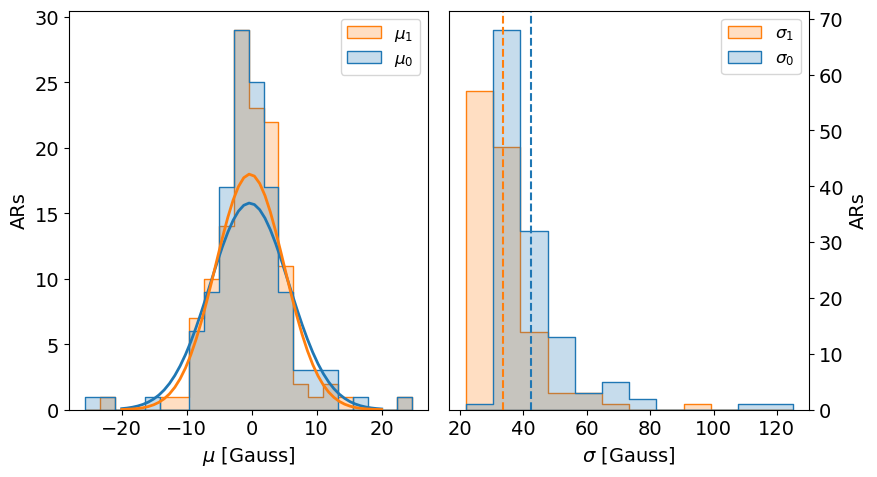

In [279]:
# Histograma para Columna1
#sns.kdeplot(df_melted,x='Valor',hue='Sigma',fill=True)
#plt.plot()
fig, axs = plt.subplots(1, 2, figsize=(9, 5),sharey=False)

sns.histplot(dfm_melted,ax=axs[0],element='step',x='Valor',hue='Mean difference',bins=22,label=['$\mu_0$','$\mu$'])
axs[0].set_xlabel('$\mu$ [Gauss]')
axs[0].set_ylabel('ARs')
axs[1].set_ylabel('ARs')


axs[0].legend(labels=['$\mu_1$','$\mu_0$'],fontsize=12,title='')

# Cálculo de estadísticas
mean1, std1 = np.mean(dfm['M0']), np.std(dfm['M0'])
mean2, std2 = np.mean(dfm['M1']), np.std(dfm['M1'])

# Configuración de los edges y fuentes
bin_edges = np.linspace(-20, 20, 22)

# Crear la curva gaussiana
x_gauss = np.linspace(-20, 20, 50)
y_gauss = norm.pdf(x_gauss, mean1, std1)  # Densidad de probabilidad gaussiana
y_gauss_scaled = y_gauss * 126 * (bin_edges[1] - bin_edges[0])  # Escalar según el histograma

# Crear la curva gaussiana
x_gauss = np.linspace(-20, 20, 50)
y_gauss2 = norm.pdf(x_gauss, mean2, std2)  # Densidad de probabilidad gaussiana
y_gauss_scaled2 = y_gauss2 * 126 * (bin_edges[1] - bin_edges[0])  # Escalar según el histograma

# Graficar la curva gaussiana
axs[0].plot(x_gauss, y_gauss_scaled, color='tab:blue', lw=2)
axs[0].plot(x_gauss, y_gauss_scaled2, color='tab:orange', lw=2)

sns.histplot(df_melted,x='Valor',hue='Sigma',fill=True, element="step",ax=axs[1],bins=12)

# Cálculo de estadísticas
mean1, std1 = np.mean(df['S0']), np.std(df['S0'])
mean2, std2 = np.mean(df['S1']), np.std(df['S1'])

# Configuración de los edges y fuentes
bin_edges = np.linspace(0, 100, 30)

dat1=df['S0'].values
dat2=df['S1'].values


# Histograma
hist1, bin_edges = np.histogram(dat1,range=(0,100), bins=30, density=False)
hist2, bin_edges = np.histogram(dat2,range=(0,100), bins=30, density=False)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Ajuste gaussiano
popt1, pcov2 = curve_fit(gaussian, bin_centers, hist1, p0=[np.max(hist1), np.mean(dat1), np.std(dat1)])
popt2, pcov2 = curve_fit(gaussian, bin_centers, hist2, p0=[np.max(hist2), np.mean(dat2), np.std(dat2)])

axs[1].legend(labels=['$\sigma_1$','$\sigma_0$'],fontsize=12,title='')

# Crear la curva gaussiana
#x_gauss = np.linspace(0, 100, 126)
#y_gauss1 = norm.pdf(x_gauss, mean1, std1)  # Densidad de probabilidad gaussiana
#y_gauss2 = norm.pdf(x_gauss, mean2, std2)  # Densidad de probabilidad gaussiana

#y_gauss_scaled1 = y_gauss1 * 126 * (bin_edges[1] - bin_edges[0])  # Escalar según el histograma
#y_gauss_scaled2 = y_gauss2 * 126 * (bin_edges[1] - bin_edges[0])  # Escalar según el histograma

# Graficar la curva gaussiana

#x_fit = np.linspace(0, 100, 400)
#axs[1].plot( x_fit,gaussian(x_fit, *popt1),  color='tab:blue', lw=2)
#axs[1].plot(x_fit, gaussian(x_fit, *popt2),  color='tab:orange', lw=2)

#axs[1].plot(x_gauss, y_gauss_scaled1, color='tab:blue', lw=2)
#axs[1].plot(x_gauss, y_gauss_scaled2, color='tab:orange', lw=2)

#x = np.linspace(bin_edges[0], bin_edges[-1], 30)
#axs[1].plot(x, gaussian(x, mus[0], sigs[0]), color='tab:blue', lw=2)
#axs[1].plot(x, gaussian(x, mus[1], sigs[1]), color='tab:orange', lw=2)

# Colocar las etiquetas del eje y a la izquierda
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()


axs[1].axvline(np.mean(dat1),color='tab:blue',linestyle='dashed')
axs[1].axvline(np.mean(dat2),color='tab:orange',linestyle='dashed')
axs[1].set_xlabel('$\sigma$ [Gauss]')
#plt.ylabel('ARs')

plt.tight_layout()

#plt.plot()

plt.savefig('./plots/sigmas.pdf',dpi=300)

In [208]:
len(hist1)

24

In [204]:
[np.max(hist1), np.mean(dat1), np.std(dat1)]

[46, 42.539652373957296, 13.69124114698545]

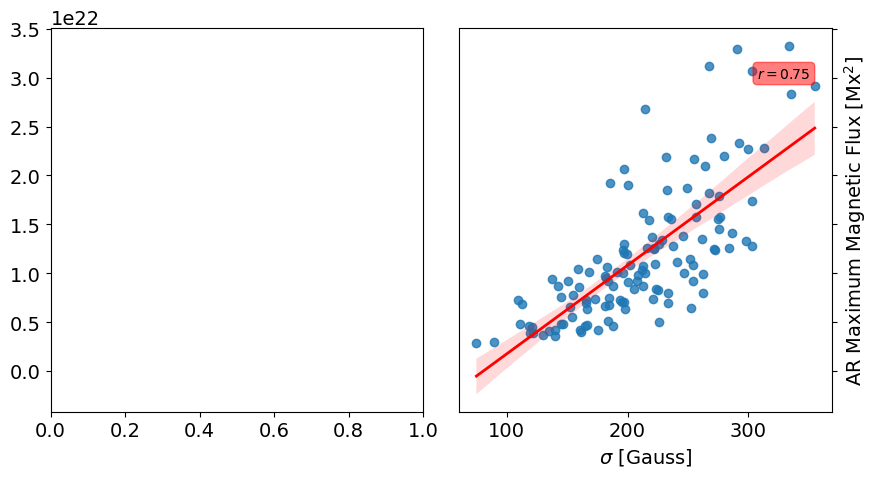

In [36]:
from scipy.stats import linregress

fig, axs = plt.subplots(1, 2, figsize=(9, 5),sharey=True)


g=sns.regplot(data=df,x='S1',y='fmax', line_kws={"color": "red", "linewidth": 2})


# Calcular la pendiente y el coeficiente de correlación
x = df['S1']
y = df['fmax']
slope, intercept, r_value, p_value, std_err = linregress(x, y)


# Agregar la pendiente y el coeficiente de correlación al gráfico
textstr = f"$r = {r_value:.2f}$"
plt.text(0.8, 0.9, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(color="red",boxstyle="round", alpha=0.5))

plt.xlabel(r'$\sigma$ [Gauss]')

plt.ylabel(r'AR Maximum Magnetic Flux [Mx$^2$]')

# Colocar las etiquetas del eje y a la izquierda
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.tight_layout()
plt.savefig('./plots/sig-flux.pdf',dpi=300)


# Flux differences

In [269]:
df1=[]

for name in list(DF0['AR'].values):
    print(str(name)+'----------------------------------')
    datad,times=opencube2(name=str(name),path='../movies')
    scl=1
    
    
    nn=DF0[DF0['AR']==name].range.values[0]
    sg0=DF0[DF0['AR']==name].sigma.values[0]
    
    mask_cube=np.load('./masks/'+str(name)+'_mask.npy')[:,:,0:nn]
    mod_cube=np.load('./models/'+str(name)+'.npy')[:,:,0:nn]
    
    data2=datad[:,:,0:nn]#*mask_cube

    sz2,sz1,nMagnetograms = (np.shape(data2))
    
    stp=round(nMagnetograms/np.shape(mod_cube)[2])
    
    data2=data2[:,:,::stp]
    mask=mask_cube[:,:,::stp]
    
    flux_ar=np.sum(np.abs(data2)/2,axis=(0,1))
    flux_mod=np.sum(np.abs(mod_cube*mask)/2,axis=(0,1))
    
    xp=np.mean([barys(data2[:,:,j],10)[0] for j in range(data2.shape[2])])
    xn=np.mean([barys(data2[:,:,j],10)[2] for j in range(data2.shape[2])])
    
    if xn > xp:
        flead=np.sum(np.abs(data2*(data2 < 0)),axis=(0,1))
        ffol=np.sum(np.abs(data2*(data2 > 0)),axis=(0,1))
    else:
        ffol=np.sum(np.abs(data2*(data2 < 0)),axis=(0,1))
        flead=np.sum(np.abs(data2*(data2 > 0)),axis=(0,1))

    
    df0=pd.DataFrame({'mag':[stp*i+1 for i in range(data2.shape[2])],'AR':[name for i in range(data2.shape[2])],
        'AR Flux':flux_ar/np.max(flux_ar),
                      'AR lead':flead/np.max(flux_ar),
                      'AR fol':ffol/np.max(flux_ar),
                      'MOD Flux':flux_mod/np.max(flux_mod)})
    
    df1.append(df0)
    
DFf=pd.concat(df1)

10132----------------------------------
133 123 33
b'21-Sep-2002 22:23:01.298' b'24-Sep-2002 03:11:01.344'
75 84
10323----------------------------------
155 193 68
b'27-Mar-2003 14:24:00.501' b'1-Apr-2003 03:12:00.557'
96 159
10344----------------------------------
231 171 68
b'25-Apr-2003 16:03:00.390' b'30-Apr-2003 04:47:00.310'
73 119
10381----------------------------------
145 137 57
b'9-Jun-2003 22:22:59.390' b'13-Jun-2003 17:34:59.340'
70 88
10569----------------------------------
96 119 68
b'4-Mar-2004 19:15:03.230' b'9-Mar-2004 08:03:03.330'
71 103
10879----------------------------------
143 151 65
b'1-May-2006 11:11:01.530' b'5-May-2006 19:11:01.450'
71 96
10900----------------------------------
163 191 68
b'15-Jul-2006 17:36:01.630' b'20-Jul-2006 06:23:01.750'
91 141
10971----------------------------------
151 169 56
b'28-Sep-2007 00:03:02.040' b'1-Oct-2007 17:36:01.940'
57 86
11024----------------------------------
137 157 48
b'4-Jul-2009 00:00:02.090' b'7-Jul-2009 04:48:02.

In [259]:
DFf

,mag,AR,AR Flux,AR lead,AR fol,MOD Flux
0,1,10132,0.168977,0.247405,0.261505,0.166293
1,2,10132,0.195980,0.269020,0.285629,0.201308
2,3,10132,0.221530,0.305714,0.294264,0.247816
3,4,10132,0.249829,0.342853,0.310431,0.281242
4,5,10132,0.264184,0.363331,0.316964,0.309131
...,...,...,...,...,...,...
17,52,9987,0.885630,1.020120,1.064857,0.981355
18,55,9987,0.905995,1.059855,1.058817,0.981769
19,58,9987,0.917753,1.080111,1.063783,0.982718
20,61,9987,0.950114,1.140527,1.063143,0.990152


,index,AR Flux,MOD Flux
0,10132,"[0.23482831027032608, 0.25593418103512455, 0.2...","[0.16629299917281745, 0.20130822567786347, 0.2..."
1,10323,"[0.3260690728456621, 0.32345425904244474, 0.32...","[0.3752878002872257, 0.3783538099360632, 0.382..."
2,10344,"[0.6646127677960589, 0.6842540242664263, 0.697...","[0.9945945819225485, 0.9951494460626323, 0.995..."
3,10381,"[0.3282207500922637, 0.3540258600988858, 0.394...","[0.2681368183001175, 0.33924128207402776, 0.44..."
4,10569,"[0.5479323463030581, 0.6714018707253008, 0.721...","[0.4163577538493981, 0.49331839577133374, 0.58..."
...,...,...,...
121,9910,"[0.7147967340686117, 0.7713093026412411, 0.821...","[0.7826875884678748, 0.8278604865941579, 0.863..."
122,9912,"[0.3694640315041808, 0.3929774023685192, 0.400...","[0.28950997729294603, 0.32659263810802136, 0.3..."
123,9931,"[0.37209741741887326, 0.41448823602954266, 0.4...","[0.3308948338150221, 0.42507170432302094, 0.51..."
124,9978,"[0.8431168547555946, 0.858119903916489, 0.9642...","[0.7995871401009801, 0.825458320772664, 0.8617..."


In [8]:
DFf2=pd.melt(DFf,id_vars=['MOD Flux'], value_vars=['AR Flux', 'AR lead','AR fol'], 
                    var_name='type', value_name='Flux')

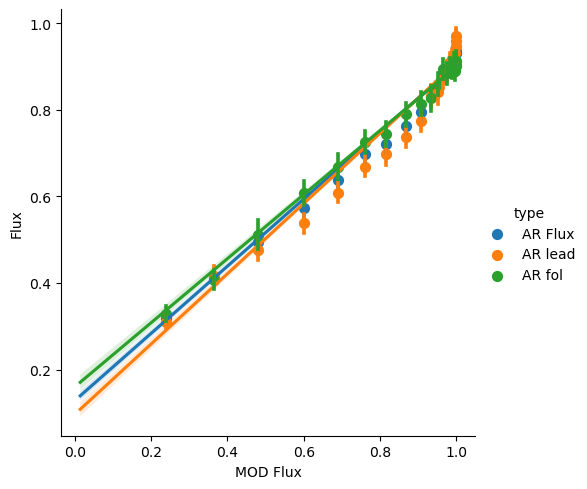

In [9]:
sns.lmplot(DFf2,x='MOD Flux',y='Flux',hue='type',x_bins=20)

In [250]:
df

,S0,S1,fmax
10132,34.795912,33.539600,9.197605e+21
10323,35.572794,28.571433,2.069278e+22
10344,46.954256,39.452816,1.367545e+22
10381,36.701032,29.377426,7.400983e+21
10569,35.353435,23.667108,4.444587e+21
...,...,...,...
9910,33.803161,27.796140,1.006051e+22
9912,36.710212,34.193144,1.448245e+22
9931,37.541796,33.143705,6.619258e+21
9978,53.161613,45.795050,1.333430e+22


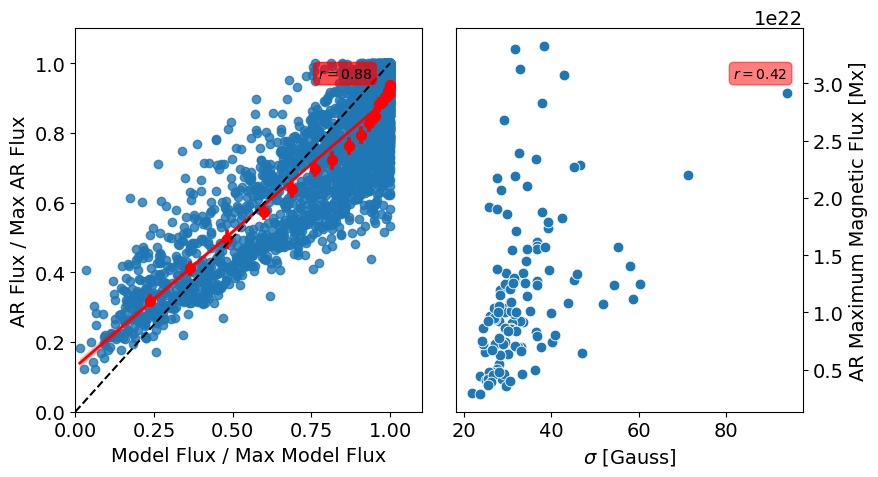

In [288]:


from scipy.stats import linregress

f, axs = plt.subplots(1, 2, figsize=(9, 5))


g=sns.scatterplot(data=df,x='S1',y='fmax',ax=axs[1],s=60)


# Calcular la pendiente y el coeficiente de correlación
x = df['S1']
y = df['fmax']
slope, intercept, r_value, p_value, std_err = linregress(x, y)


# Agregar la pendiente y el coeficiente de correlación al gráfico
textstr = f"$r = {r_value:.2f}$"
axs[1].text(0.8, 0.9, textstr, transform=axs[1].transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(color="red",boxstyle="round", alpha=0.5))

axs[1].set_xlabel(r'$\sigma$ [Gauss]')

axs[1].set_ylabel(r'AR Maximum Magnetic Flux [Mx]')

# Colocar las etiquetas del eje y a la izquierda
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

#plt.tight_layout()
#plt.savefig('./plots/sig-flux.pdf',dpi=300)



sns.regplot(DFf,y='AR Flux',x='MOD Flux', line_kws={"color": "red", "linewidth": 2},ax=axs[0])
sns.regplot(DFf,y='AR Flux',x='MOD Flux',ax=axs[0],x_bins=20,color='red', line_kws={"color": "red", "linewidth": 0.1})

axs[0].plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),color='black',linestyle='dashed')
axs[0].set_ylabel('AR Flux / Max AR Flux')
axs[0].set_xlabel('Model Flux / Max Model Flux')
axs[0].set_xlim(0,1.1)
axs[0].set_ylim(0,1.1)

# Calcular la pendiente y el coeficiente de correlación
x = DFf['MOD Flux']
y = DFf['AR Flux']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Agregar la pendiente y el coeficiente de correlación al gráfico
textstr = f"$r = {r_value:.2f}$"
axs[0].text(0.7, 0.9, textstr, transform=axs[0].transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(color='red',boxstyle="round", alpha=0.7))

# Colocar las etiquetas del eje y a la izquierda
#plt.gca().yaxis.set_label_position("right")
#plt.gca().yaxis.tick_right()

#fig.tight_layout()

f.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig('./plots/fluxes.pdf',dpi=300)



#sns.lmplot(DFf,x='AR lead',y='MOD Flux',x_bins=20)
#sns.lmplot(DFf,x='AR fol',y='MOD Flux',x_bins=20)


In [262]:
# Calcular la pendiente y el coeficiente de correlación
x = DFf['MOD Flux']
y = DFf['AR Flux']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [264]:
r_value

0.9006020775619231

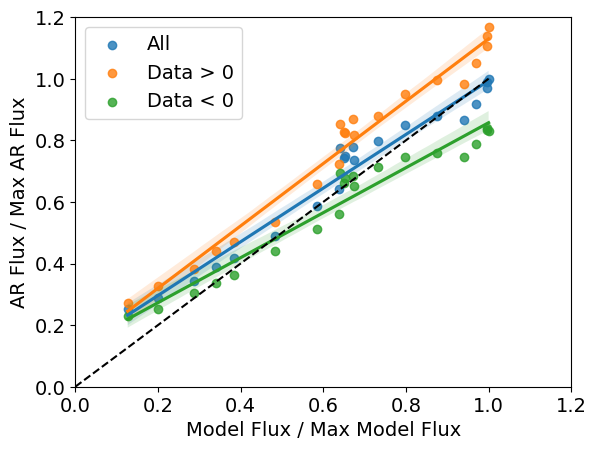

In [19]:
sns.regplot(DFf[DFf['AR']==10268],y='AR Flux',x='MOD Flux',label='All')
sns.regplot(DFf[DFf['AR']==10268],y='AR fol',x='MOD Flux',label='Data > 0')
sns.regplot(DFf[DFf['AR']==10268],y='AR lead',x='MOD Flux',label='Data < 0')

plt.rcParams.update({'font.size': 14})

plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),color='black',linestyle='dashed')
plt.ylabel('AR Flux / Max AR Flux')
plt.xlabel('Model Flux / Max Model Flux')
plt.xlim(0,1.2)
plt.ylim(0,1.2)
plt.legend()

plt.savefig('./plots/fluxes.pdf',dpi=300)



#sns.lmplot(DFf,x='AR lead',y='MOD Flux',x_bins=20)
#sns.lmplot(DFf,x='AR fol',y='MOD Flux',x_bins=20)


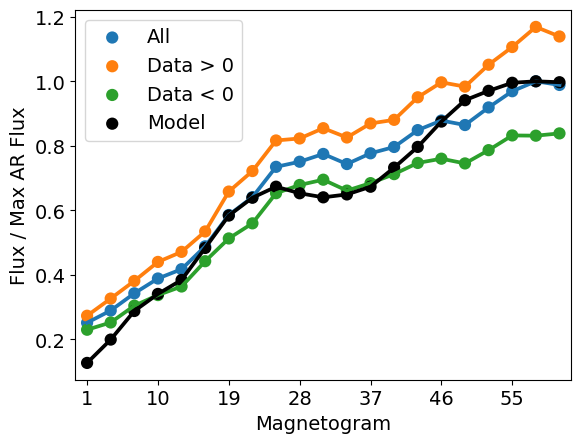

In [14]:

from matplotlib.ticker import MaxNLocator
sns.pointplot(DFf[DFf['AR']==10268],y='AR Flux',x='mag',label='All')
sns.pointplot(DFf[DFf['AR']==10268],y='AR fol',x='mag',label='Data > 0',color='tab:orange')
sns.pointplot(DFf[DFf['AR']==10268],y='AR lead',x='mag',label='Data < 0',color='tab:green')
sns.pointplot(DFf[DFf['AR']==10268],y='MOD Flux',x='mag',label='Model',color='black')
plt.rcParams.update({'font.size': 14})

plt.xlabel('Magnetogram')
plt.ylabel('Flux / Max AR Flux')
ax=plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
#plt.xlim(0,1.1)
#plt.ylim(0,1.1)
plt.legend()

plt.savefig('./plots/fluxes2.pdf',dpi=300)

In [ ]:
sns.regplot(DFf,x='AR Flux',y='MOD Flux',x_bins=20)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),color='black',linestyle='dashed')
plt.xlabel('AR Flux / Max AR Flux')
plt.ylabel('Model Flux / Max Model Flux')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.savefig('./plots/fluxes.pdf',dpi=300)

In [11]:
DFf

,AR Flux,AR lead,AR fol,MOD Flux
0,0.234828,0.228322,0.241334,0.166293
1,0.255934,0.248270,0.263598,0.201308
2,0.276850,0.282133,0.271567,0.247816
3,0.301447,0.316408,0.286486,0.281242
4,0.313911,0.335306,0.292516,0.309131
...,...,...,...,...
17,0.902994,0.883618,0.922369,0.981355
18,0.917587,0.918037,0.917138,0.981769
19,0.928511,0.935583,0.921439,0.982718
20,0.954399,0.987914,0.920885,0.990152
